## Seguimiento - Expected Threat (Position-based)

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
import os
import pathlib
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

En esta sección implementamos el modelo de xT del mismo modo que Karun Singh en https://karun.in/blog/expected-threat.html

### Opening Data

In [2]:
file_name = 'events_England.json'
path = os.path.join(str(pathlib.Path().resolve()), 'data', 'WyScout','events', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)
df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


Filtramos el dataframe para quedarnos solo con las acciones que implican movimiento de balón

In [3]:
df.subEventName.value_counts()

Simple pass                251405
Ground attacking duel       53859
Ground defending duel       53737
Air duel                    37760
Touch                       34409
Ground loose ball duel      31332
Ball out of the field       27331
High pass                   25067
Head pass                   21332
Throw in                    17050
Cross                       12251
Clearance                   11784
Launch                      10247
Shot                         8451
Foul                         7522
Free Kick                    7279
Goal kick                    6061
Smart pass                   5881
Acceleration                 4892
Corner                       3910
Hand pass                    2474
Reflexes                     2124
Free kick cross              1693
                             1558
Goalkeeper leaving line      1266
Save attempt                 1225
Free kick shot                350
Hand foul                     275
Whistle                       204
Out of game fo

### Acciones con movimiento

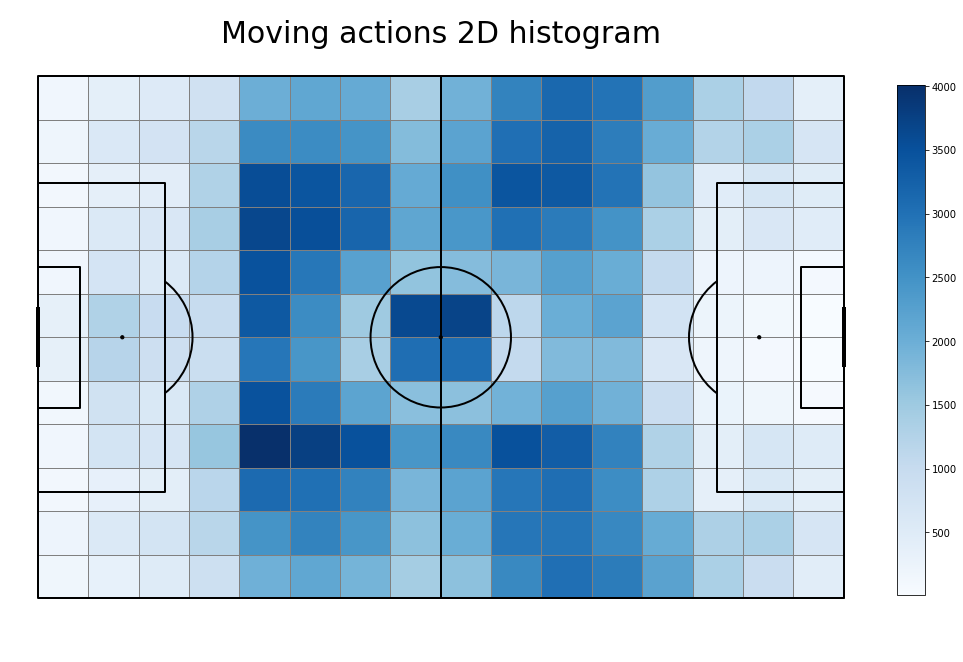

In [4]:
next_event = df.shift(-1, fill_value=0)
df['nextEvent'] = next_event['subEventName']

# Si la accion termina con el balón fuera del campo...
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)
moving_actions = ['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross','Acceleration']
move_df = df.loc[df['subEventName'].isin(moving_actions)]
# pero si la acción termina con el balón fuera del campo lo quitamos

move_df = move_df[move_df['kickedOut']!=1]

# hacemos columnas con las coordenadas y las normalizamos según las medidas de instat/uefa
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

# Graficamos el número de acciones seleccionadas por bin
pitch = Pitch(line_color='black',pitch_type='uefa', line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

stat = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)
pcm  = pitch.heatmap(stat, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = stat["statistic"]

### Tiros

Además de todas las acciones que implican movimiento, para calcular el xT necesitamos tiros y goles. En primer lugar, los filtramos del dataframe y los graficamos por zona.

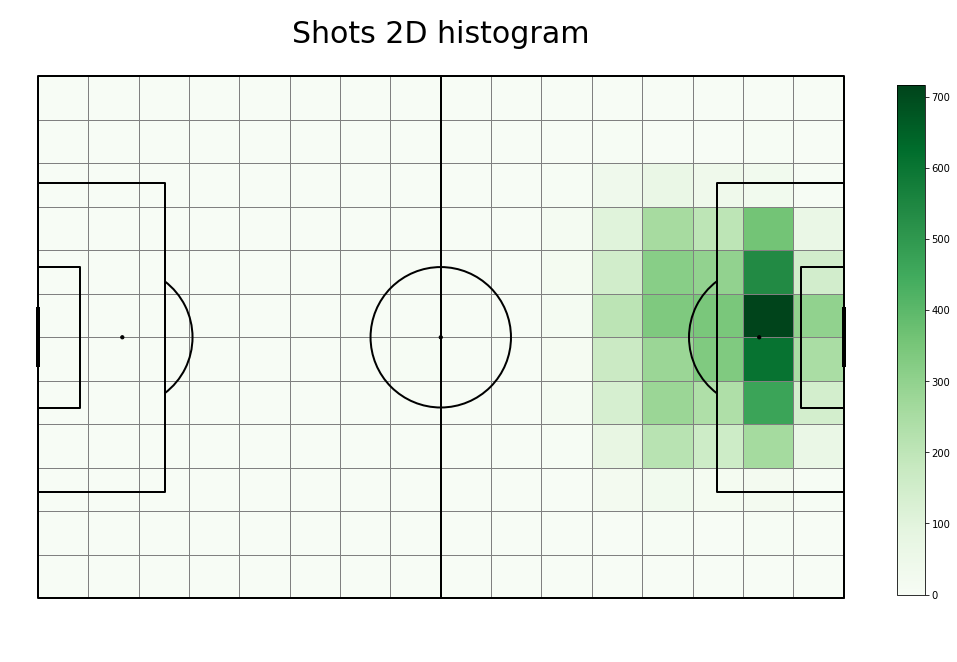

In [5]:
#get shot df
shot_df = df.loc[df['subEventName'] == "Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

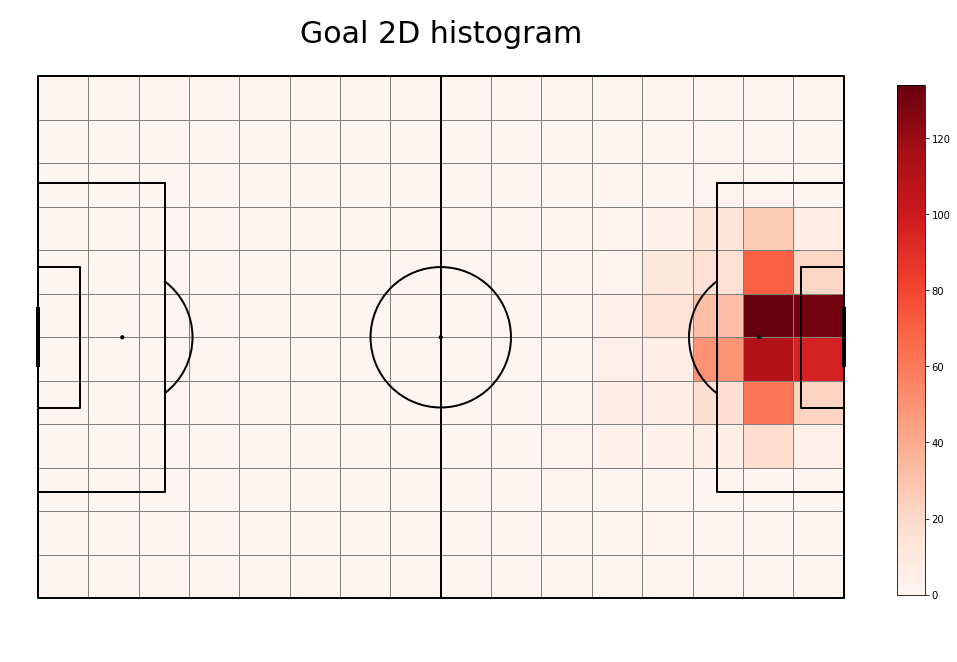

In [6]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

### Probabilidades

Necesitamos calcular la probabilidad, por área, de moverse (pasar o conducir) y la de tirar. Una vez tenemos los tiros y los goles, también podemos calcular la de marcar, que es básicamente lo mismo que hacer un mapa de xG

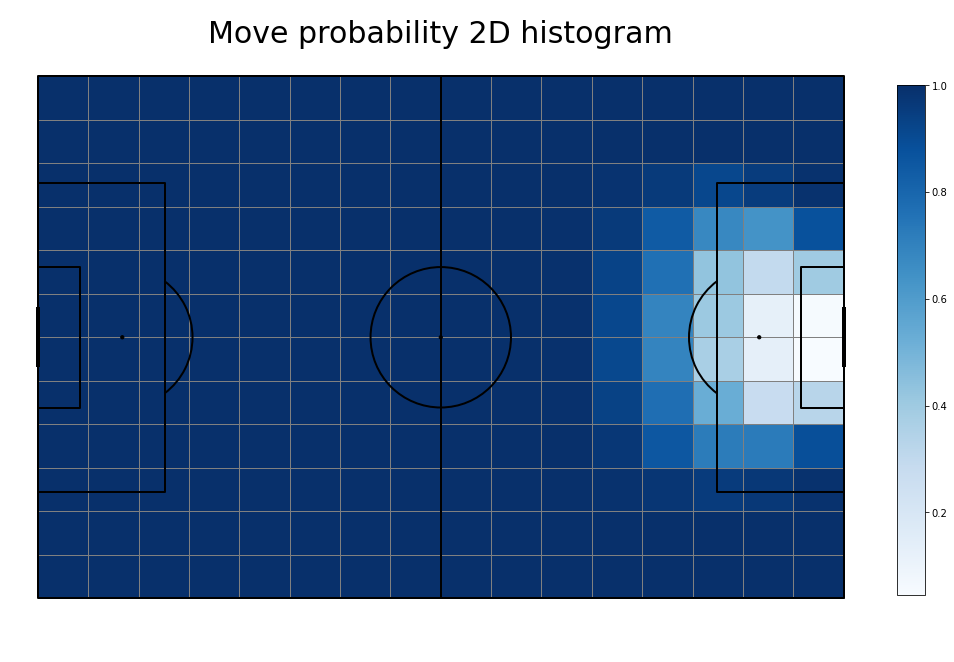

In [7]:
move_prob = move_count/(move_count+shot_count)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
stat["statistic"] = move_prob
pcm  = pitch.heatmap(stat, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

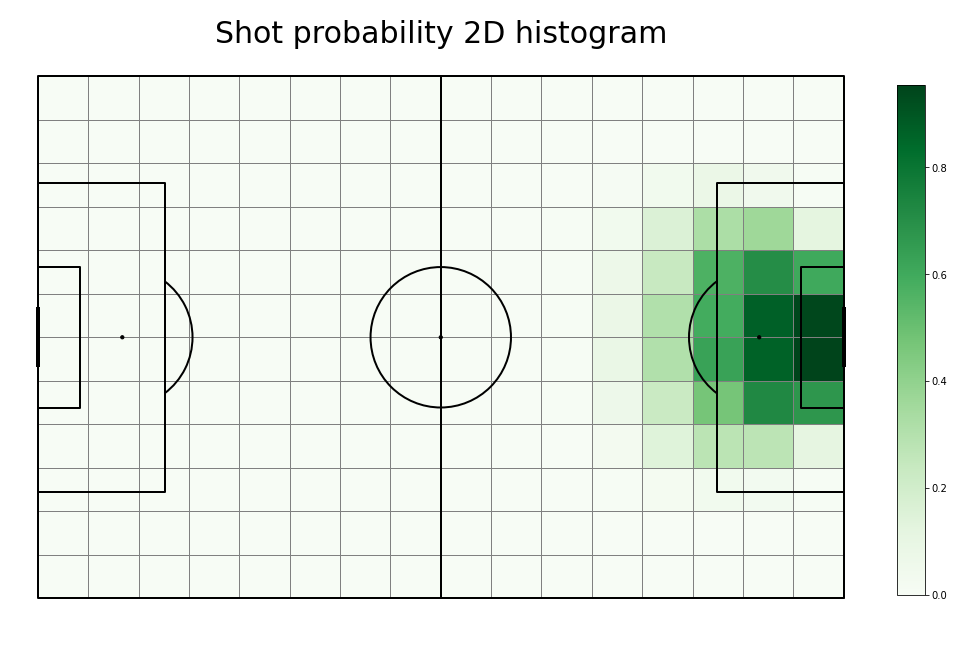

In [8]:
shot_prob = shot_count/(move_count+shot_count)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_prob
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

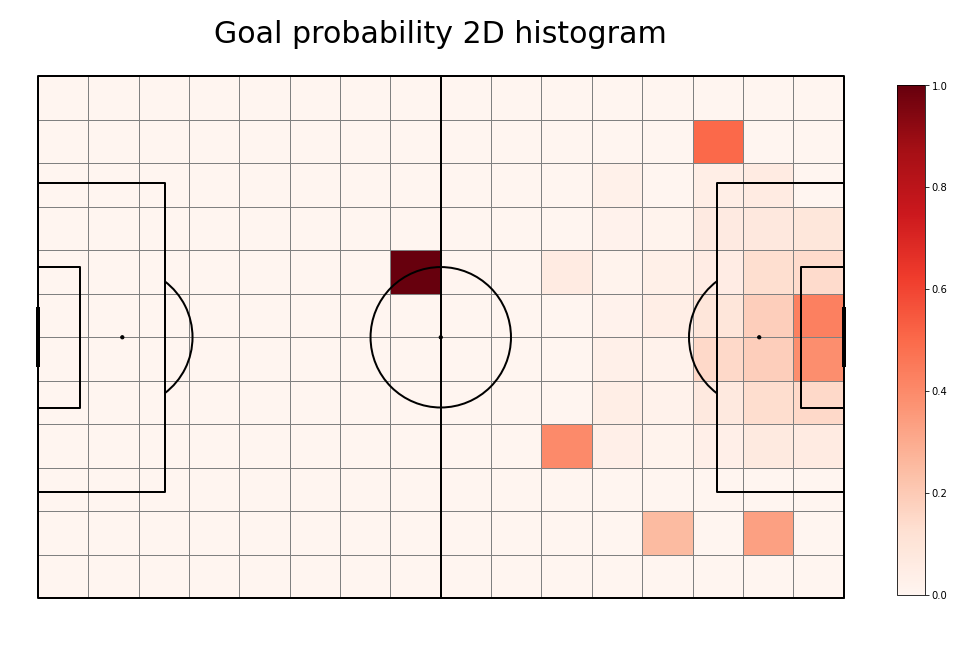

In [9]:
goal_prob = goal_count/shot_count
goal_prob[np.isnan(goal_prob)] = 0
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_prob
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

## Matrices de Transición

Lo siguiente es, para cada punto del campo, calcular una matriz de transición, es decir, la probabilidad de ir desde ese punto a cualquiera de los otros, suponiendo que la decisión sea pasar o conducir, y no tirar.

Lo que haremos es crear dos columnas en la que marcaremos el bin de inicio y el bin donde acaba la acción. Haremos groupby por el bin de inicio y contaremos. Tras ello, para cada sector, calcularemos la probabilidad de ir a cada uno de los otros sectores. Para acabar, visualizaremos la matriz de transición para un punto concreto del campo.

In [10]:
move_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,x,y,end_x,end_y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,51.45,34.68,32.55,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,32.55,14.96,53.55,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,53.55,17.00,36.75,19.72
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,0,36.75,19.72,43.05,3.40
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,0,43.05,3.40,75.60,8.16


In [11]:
binned_statistic_2d

<function scipy.stats._binned_statistic.binned_statistic_2d(x, y, values, statistic='mean', bins=10, range=None, expand_binnumbers=False)>

In [12]:
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
move_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,x,y,end_x,end_y,start_sector,end_sector
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,51.45,34.68,32.55,14.96,"(8, 7)","(5, 3)"
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,32.55,14.96,53.55,17.00,"(5, 3)","(9, 4)"
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,53.55,17.00,36.75,19.72,"(9, 4)","(6, 4)"
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,0,36.75,19.72,43.05,3.40,"(6, 4)","(7, 1)"
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,0,43.05,3.40,75.60,8.16,"(7, 1)","(12, 2)"


In [13]:
# Agrupando

starts = move_df.groupby('start_sector')['eventId'].count().reset_index()
starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i,j in starts.iterrows():
    start_sector = j['start_sector']
    count_starts = j['count_starts']
    
    df_sector = move_df[move_df["start_sector"] == start_sector]
    
    ends = df_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    matrix = np.zeros((12,16))
    for k,h in ends.iterrows():
        end_sector = h['end_sector']
        value = h['count_ends']
        matrix[end_sector[1]-1][end_sector[0] - 1] = value
    matrix = matrix / count_starts
    transition_matrices.append(matrix)

Zona: (8, 7)


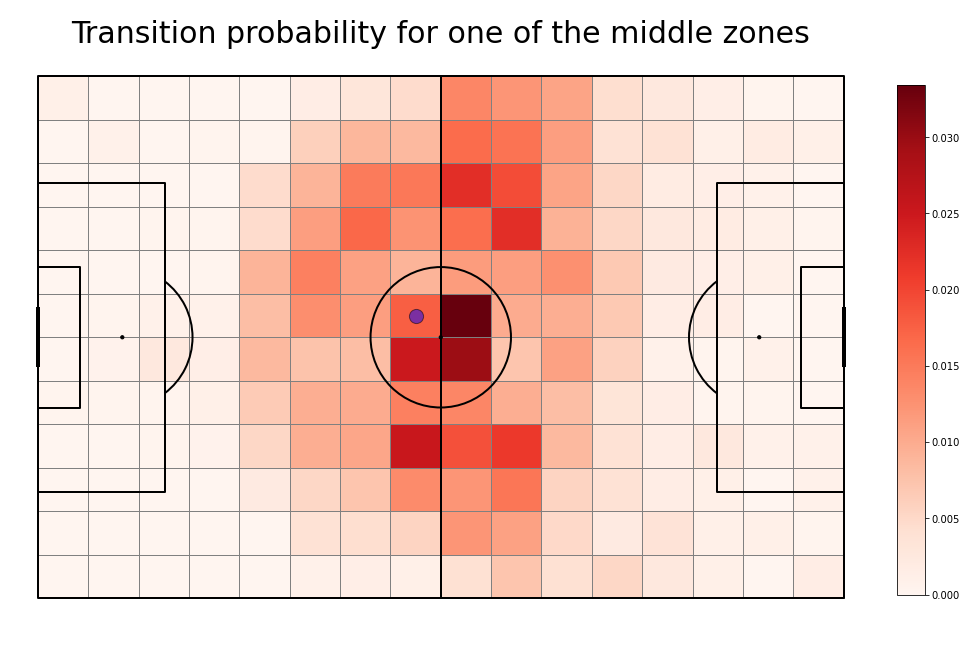

In [14]:
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
stat["statistic"] = transition_matrices[90]
print('Zona: {}'.format(starts.iloc[90].start_sector))
pcm  = pitch.heatmap(stat, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
pitch.scatter(stat['cx'][starts.iloc[90].start_sector[0]][starts.iloc[90].start_sector[1]],
              stat['cy'][starts.iloc[90].start_sector[1]-1][starts.iloc[90].start_sector[0]-1],
              alpha = 0.5, color = "blue", ax=ax['pitch'], edgecolors="black",s=200)
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

Estamos listos ya para calcular xT. Lo primero es calcular la probabilidad de tiro * la probabilidad de gol suponiendo el tiro. Ello nos da la probabilidad de gol directo -**shoot_expected_payoff**-.

También debemos de calcular el **move_expected_payoff**, que no es otra cosa que la matriz de transiciones multiplicada por lo contrario a la probabilidad de tiro, es decir, la probabilidad de moverse.

**xT = shoot_expected_payoff + move_expected_payoff**

Debemos iterarlo 5 veces para tener el xT real/final.

### Calculando xT

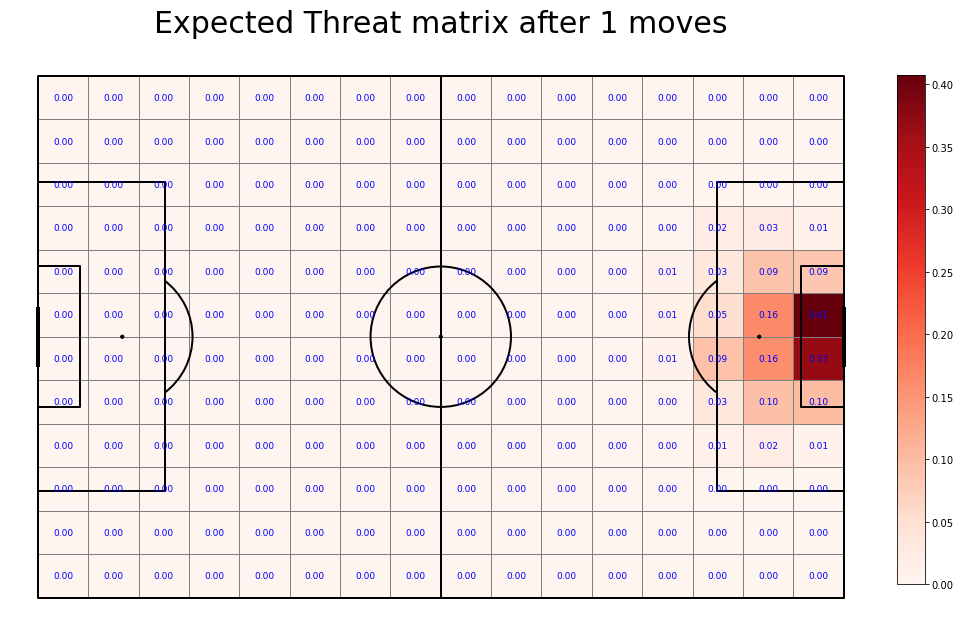

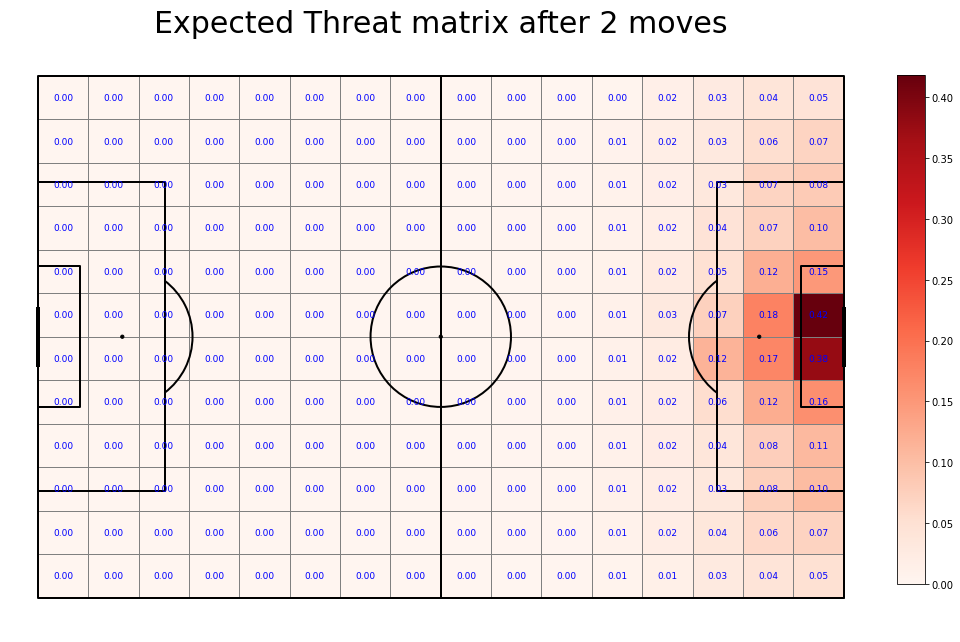

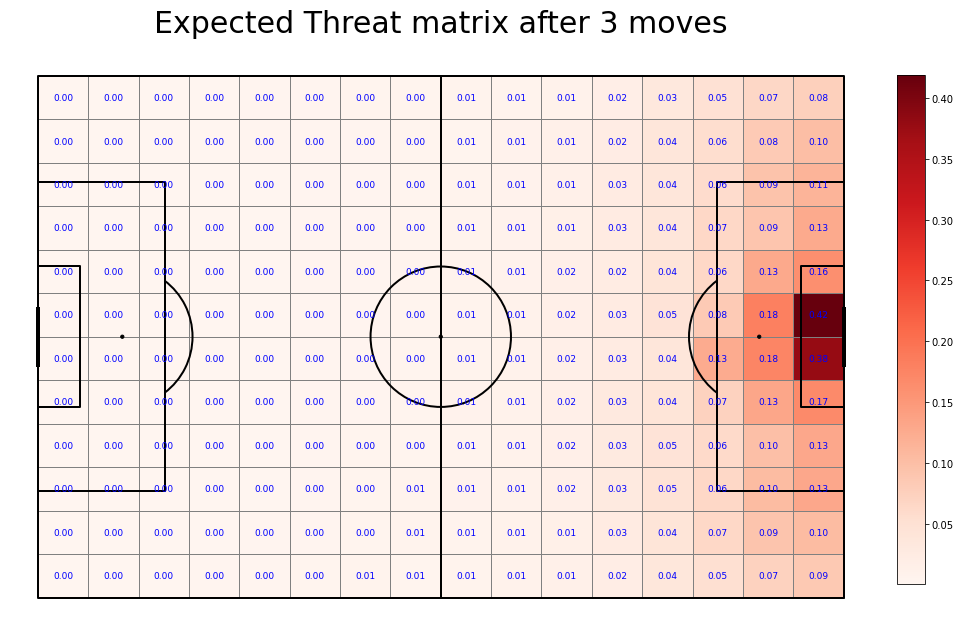

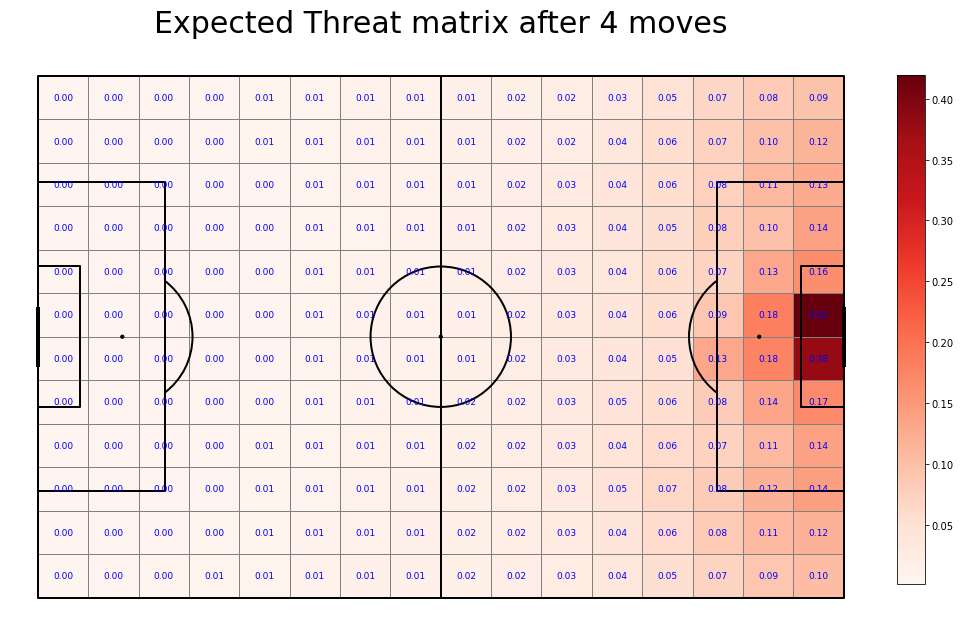

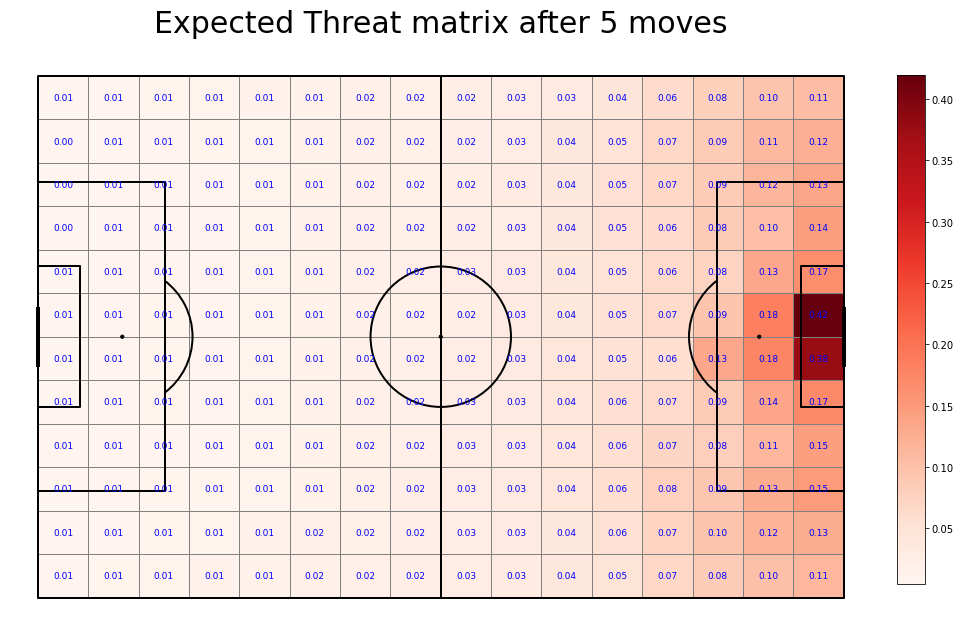

In [15]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12,16))

for i in range(5):
    shoot_expected_payoff = goal_prob*shot_prob
    move_expected_payoff = move_prob*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = move_expected_payoff + shoot_expected_payoff
    
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    stat['statistic'] = xT
    
    pcm  = pitch.heatmap(stat, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(stat, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

### Aplicación a los datos

El siguiente paso es tomar las acciones exitosas progresivas y calcular el xT agregado.

In [16]:
succ_moves = move_df[move_df.apply(lambda x:{'id':1801} in x.tags, axis=1)] # taking successful moves
succ_moves['xT_added'] = succ_moves.apply(lambda x: xT[x.end_sector[1]-1][x.end_sector[0]-1] - xT[x.start_sector[1]-1][x.start_sector[0]-1],
                                          axis=1)
value_adding_actions = succ_moves[succ_moves["xT_added"] > 0]

In [17]:
# Agrupamos por jugador
xT_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()

path = os.path.join(str(pathlib.Path().resolve()),"data", 'WyScout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)

xT_player = pd.merge(xT_player,player_df[['playerId','shortName','role']])
xT_player.head()

,playerId,xT_added,shortName,role
0,36,8.917706,T. Alderweireld,Defender
1,38,2.122789,D. Blind,Defender
2,48,18.393583,J. Vertonghen,Defender
3,54,24.278698,C. Eriksen,Midfielder
4,56,0.850768,D. Klaassen,Midfielder


In [18]:
path = os.path.join(str(pathlib.Path().resolve()),"data","WyScout","minutes_played", 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = pd.merge(xT_player,minutes, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
#calculating per 90
summary["xT_per_90"] = summary["xT_added"]*90/summary["minutesPlayed"]

#adjusting for possesion
path = os.path.join(str(pathlib.Path().resolve()),"data","WyScout","minutes_played", 'player_possession_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

summary["xT_adjusted_per_90"] = (summary["xT_added"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(20)

,shortName,xT_adjusted_per_90
27,Fàbregas,1.824848
271,K. De Bruyne,1.490366
68,P. Pogba,1.446572
22,M. Özil,1.412121
78,J. Shelvey,1.381687
39,Philippe Coutinho,1.365615
117,David Silva,1.302552
118,J. Milner,1.289116
77,J. Henderson,1.284486
250,E. Hazard,1.278121


## Challenge
- Don't remove unsuccessful and non-progressive actions. Assign -xT for unsuccessful ones!

In [19]:
move_df['xT_added'] = move_df.apply(lambda x: xT[x.end_sector[1]-1][x.end_sector[0]-1] - xT[x.start_sector[1]-1][x.start_sector[0]-1],
                                          axis=1)


# Assessing unsuccessful moves
move_df['xT_added'] = np.where(move_df.index.isin(succ_moves.index),
                               move_df['xT_added'],move_df.apply(lambda x: -1* xT[x.start_sector[1]-1][x.start_sector[0]-1],
                                          axis=1))

#group by player
xT_by_player = move_df.groupby(["playerId"])["xT_added"].sum().reset_index()

#merging player name
path = os.path.join(str(pathlib.Path().resolve()),"data", 'WyScout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]

summary = xT_by_player.merge(to_merge, how = "left", on = ["playerId"])

path = os.path.join(str(pathlib.Path().resolve()),"data","WyScout","minutes_played", 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
#calculating per 90
summary["xT_per_90"] = summary["xT_added"]*90/summary["minutesPlayed"]

#adjusting for possesion
path = os.path.join(str(pathlib.Path().resolve()),"data","WyScout","minutes_played", 'player_possession_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

summary["xT_adjusted_per_90"] = (summary["xT_added"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(20)

,shortName,xT_adjusted_per_90
0,T. Alderweireld,0.703003
328,A. Laporte,0.665369
295,N. Otamendi,0.640871
27,Fàbregas,0.599918
114,V. Kompany,0.597362
187,J. Stones,0.592585
365,W. Hoedt,0.580187
217,J. Matip,0.561200
3,R. Klavan,0.560970
78,J. Shelvey,0.548026
